# Capture Images

In [1]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import time
import motors
import cv2
import pyzed.sl as sl
import math
import numpy as np
import sys
import threading
import matplotlib.pyplot as plt

In [2]:

#create widgets for the displaying of the image
display_color = widgets.Image(format='jpeg', width='30%') #determine the width of the color image
display_depth = widgets.Image(format='jpeg', width='30%')  #determine the width of the depth image
layout=widgets.Layout(width='100%')
sidebyside = widgets.HBox([display_color, display_depth],layout=layout) #horizontal 
display(sidebyside)

class Camera():
    def __init__(self):
        super(Camera, self).__init__()

        self.zed = sl.Camera()
        # Create a InitParameters object and set configuration parameters
        init_params = sl.InitParameters()
        init_params.camera_resolution = sl.RESOLUTION.VGA #VGA(672*376), HD720(1280*720), HD1080 (1920*1080) or ...
        init_params.depth_mode = sl.DEPTH_MODE.ULTRA  # Use ULTRA depth mode
        init_params.coordinate_units = sl.UNIT.MILLIMETER  # Use meter units (for depth measurements)

        # Open the camera
        status = self.zed.open(init_params)
        if status != sl.ERROR_CODE.SUCCESS: #Ensure the camera has opened succesfully
            print("Camera Open : "+repr(status)+". Exit program.")
            self.zed.close()
            exit(1)

         # Create and set RuntimeParameters after opening the camera
        self.runtime = sl.RuntimeParameters()

        #flag to control the thread
        self.thread_runnning_flag = False

        # Get the height and width
        camera_info = self.zed.get_camera_information()
        self.width = camera_info.camera_configuration.resolution.width
        self.height = camera_info.camera_configuration.resolution.height
        self.image = sl.Mat(self.width,self.height,sl.MAT_TYPE.U8_C4, sl.MEM.CPU)
        self.depth = sl.Mat(self.width,self.height,sl.MAT_TYPE.F32_C1, sl.MEM.CPU)
        self.point_cloud = sl.Mat(self.width,self.height,sl.MAT_TYPE.F32_C4, sl.MEM.CPU)
        self.output = None

        self.count = 0

    def _capture_frames(self):
        while(self.thread_runnning_flag==True): #continue until the thread_runnning_flag is set to be False
           
            if self.zed.grab(self.runtime) == sl.ERROR_CODE.SUCCESS:
                
                
                # Retrieve Left image
                self.zed.retrieve_image(self.image, sl.VIEW.LEFT)
                # Retrieve depth map. Depth is aligned on the left image
                self.zed.retrieve_measure(self.depth, sl.MEASURE.DEPTH)
                # Retrieve colored point cloud. Point cloud is aligned on the left image.
                self.zed.retrieve_measure(self.point_cloud, sl.MEASURE.XYZRGBA)

                self.color_value = self.image.get_data()
                cv2.putText(self.color_value, 'o', (self.width//2,self.height//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                display_color.value = bgr8_to_jpeg(self.color_value)

                
                #self.output.write(self.color_value)
                self.depth_image = np.asanyarray(self.depth.get_data())
                depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(self.depth_image, alpha=0.03), cv2.COLORMAP_JET) 
                cv2.putText(depth_colormap, str(self.depth_image[self.height//2,self.width//2]), (self.width//2,self.height//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                display_depth.value = bgr8_to_jpeg(depth_colormap)
                
                # # We measure the distance camera - object using Euclidean distance
                x = round(self.width / 2)
                y = round(self.height / 2)
                err, point_cloud_value = self.point_cloud.get_value(x, y)  
                # Your mission here 
    
    def start(self): #start the data capture thread
        if self.thread_runnning_flag == False: #only process if no thread is running yet
            self.thread_runnning_flag=True #flag to control the operation of the _capture_frames function
            self.thread = threading.Thread(target=self._capture_frames) #link thread with the function
            self.thread.start() #start the thread       

    def stop(self): #stop the data capture thread
        if self.thread_runnning_flag == True:
            self.thread_runnning_flag = False #exit the while loop in the _capture_frames
            self.thread.join() #wait the exiting of the thread    
            self.output.release() 

    def screenshot(self, direction):
        image = self.color_value
        cv2.imwrite(f"{direction}_{str(self.count)}.png", image)
        self.count += 1

def bgr8_to_jpeg(value):#convert numpy array to jpeg coded data for displaying 
    return bytes(cv2.imencode('.jpg',value)[1])

#initialize the Robot class
robot = motors.MotorsYukon(mecanum=False)

def on_text_change(input_value):
    if not input_value:
        return
    if(input_value[-1] == 'w'): #only use the last letter
        camera.screenshot('forward')
        robot.forward(0.1) 
        time.sleep(0.1)
        robot.stop()
    elif(input_value[-1] == 's'):
        camera.screenshot('backward')
        robot.backward(0.1)
        time.sleep(0.1)
        robot.stop()
    elif(input_value[-1] == 'a'):
        camera.screenshot('left')
        robot.left(0.1) 
        time.sleep(0.1)
        robot.stop()
    elif(input_value[-1] == 'd'):
        camera.screenshot('right')
        robot.right(0.1)
        time.sleep(0.1)
        robot.stop()
    elif(input_value[-1] == 't'):
        camera.screenshot('static')
        print("Saved")
    elif(input_value[-1] == 'q'):
        robot.stop() 
text_input = widgets.Text(value='', placeholder='Type something', description='Input:', disabled=False)
#text_input.observe(on_text_change, names='value')
interact(on_text_change, input_value='')

camera = Camera()

camera.start() # start capturing the data

interactive(children=(Text(value='', description='input_value'), Output()), _dom_classes=('widget-interact',))

[2025-03-19 10:47:09 UTC][ZED][INFO] Logging level INFO
[2025-03-19 10:47:09 UTC][ZED][INFO] Logging level INFO
[2025-03-19 10:47:09 UTC][ZED][INFO] Logging level INFO
[2025-03-19 10:47:10 UTC][ZED][INFO] [Init]  Depth mode: ULTRA
[2025-03-19 10:47:11 UTC][ZED][INFO] [Init]  Camera successfully opened.
[2025-03-19 10:47:11 UTC][ZED][INFO] [Init]  Camera FW version: 1523
[2025-03-19 10:47:11 UTC][ZED][INFO] [Init]  Video mode: VGA@100
[2025-03-19 10:47:11 UTC][ZED][INFO] [Init]  Serial Number: S/N 34032459


# Extracting Yellow from Image

In [3]:
def extract_yellow(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_bound = np.array([30,40,120])
    upper_bound = np.array([75, 255, 255])

    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    return cv2.bitwise_and(frame, frame, mask=mask), mask

In [ ]:
def centre_rope(frame, mask):
    contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        x,y,w,h = cv2.boundingRect(largest_contour)

        centre_x = x + w // 2
        centre_y = y + h // 2
        
        margin_width = 200
        margin_height = 150
        
        x1 = max(centre_x - margin_width // 2, 0)
        y1 = max(centre_y - margin_height // 2, 0)
        x2 = min(centre_x + margin_width // 2, frame.shape[1])
        y2 = min(centre_y + margin_height // 2, frame.shape[0])
        cropped_image = frame[y1:y2,x1:x2]
        
        rope_centre_x = x + w // 2
        return cropped_image, (centre_x, centre_y)
    return None, None

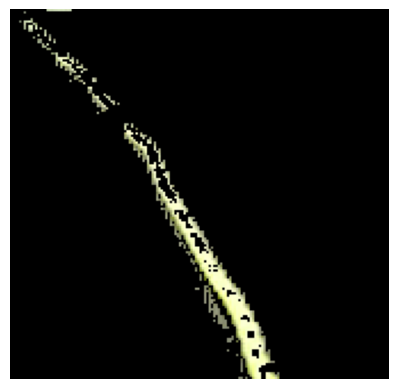

In [11]:
img = cv2.imread("forward_0.png")
frame, mask = extract_yellow(img)

    margin = 20
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + w + margin, image.shape[1])
    y2 = min(y + h + margin, image.shape[0])
    cropped_image = frame[y1:y2,x1:x2]

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.axis('off')  # Turn off axis
plt.show()

# Zip and Download Dataset

In [1]:
import shutil
from IPython.display import FileLink

# Path to the folder you want to zip
folder_path = 'images_cropped'
output_zip = 'images_cropped.zip'  # Desired name for the zip file

# Create a zip archive of the folder
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_path)

# Provide a download link
FileLink(output_zip)

/home/robotics/Documents/notebooks/images_cropped.zip